In [1]:
import numpy as np
import scipy.stats as sps
import numba as nb
from matplotlib import pyplot as plt
import implied_vol

def heston_phi(u, tau, v0, theta, rho, k, sig):
    xi = k - sig * rho * u * 1j
    d = np.sqrt( xi ** 2 + sig**2 * (1j * u + u ** 2) + 0j)
    
    s = np.sinh(d*tau/2)
    c = np.cosh(d*tau/2)
    A1 = (1j*u + u**2)*s
    A2 = d*c + xi*s
    A = A1 / A2
    
    D = np.log(d) + (k-d)*tau/2 - np.log((d+xi)/2 + (d-xi)/2*np.exp(-d * tau))
    
    pred_phi = np.exp(-k * theta * rho * tau * u * 1j / sig - A * v0 + 2 * k * theta / sig ** 2 * D)
    return pred_phi


def get_mesh(Nu):
    tn = np.linspace(0, 1, (Nu // 2) + 1)
    h = tn[1] - tn[0]
    tn = tn[:-1] + h / 2.0
    a = 30
    n = 1
    u1 = a * (tn ** n)
    h1 = h * a * n * (tn ** (n-1))
    u2 = a + a * n * (-np.log(1 - tn))
    h2 = h * a * n / (1 - tn)
    
    un = np.concatenate((u1, u2))
    hn = np.concatenate((h1, h2))
    return un, hn


def heston_option_price(S, K, T, Nu, r, heston_params, is_call=True):
    un, hn = get_mesh(Nu)

    un = un.reshape(1, -1)
    hn = hn.reshape(1, -1)
    
    xn = np.log(S * np.exp(r * T) / K).reshape(-1, 1)
    
    phi1 = heston_phi(un, T.reshape(-1, 1), *heston_params)
    phi2 = heston_phi(un - 1j, T.reshape(-1, 1), *heston_params)
        
    F1 = np.exp(1j * un * xn) * phi1 / (1j * un)
    F2 = np.exp(1j * un * xn) * phi2 / (1j * un)
    
    F1 = F1.real * hn
    F2 = F2.real * hn
    
    integral1 = np.sum(F1, axis=-1) / np.pi
    integral2 = np.sum(F2, axis=-1) / np.pi
    if is_call:
        P1 = 0.5 + integral1
        P2 = 0.5 + integral2
        res = S * P2 - np.exp(-r * T) * K * P1
    else:
        P1 = 0.5 - integral1
        P2 = 0.5 - integral2
        res = np.exp(-r * T) * K * P1 - S * P2
    return res

In [2]:
#heston parameters
v_0 = 0.01
theta = 0.02
rho = -0.5
k = 5.0
sigma = 0.23

heston_params = np.asarray([v_0, theta, rho, k, sigma])

In [3]:
#Option parameters:

S = 100.0

T = 2.0
r = 0.01
Nk = 150
KK = S * np.exp(r * T) * np.linspace(0.5, 1.9, Nk)
TT = np.zeros_like(KK) + T

Nu = 200

In [4]:
prices = heston_option_price(S, KK, TT, Nu, r, heston_params)

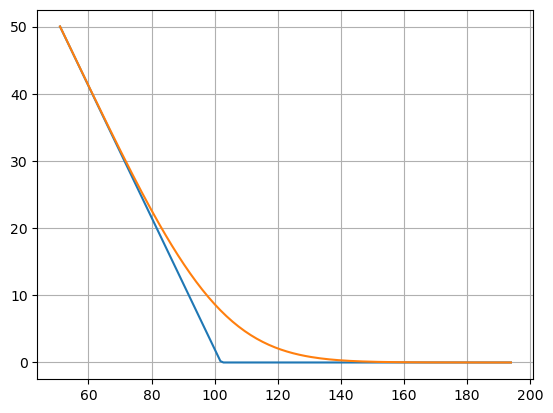

In [5]:
plt.plot(KK, np.clip(S - np.exp(-r * T) * KK, min=0, max=np.inf))
plt.plot(KK, prices)
plt.grid()
plt.show()

In [7]:
heston_params

array([ 0.01,  0.02, -0.5 ,  5.  ,  0.23])

In [21]:
params_grid = np.array([
    [0.01, 0.02, 0.05],
    [-0.5, 0, 0.7],
    [0.1, 1, 5],
    [0.01, 0.2, 1]
])

ivs = np.zeros(params_grid.shape + (len(KK), ))
F = S * np.exp(r * T)

heston_params = np.asarray([v_0, theta, rho, k, sigma])
heston_params_ = heston_params[1:]
for i in range(params_grid.shape[0]):
    for j in range(params_grid.shape[1]):
        prms = heston_params_.copy()
        prms[i] = params_grid[i, j]
        prices = heston_option_price(S, KK, TT, Nu, r, np.r_[prms[0], prms])
        ivs[i, j] = implied_vol.get_implied_vol(prices * np.exp(r * T), F, KK, T)

Final residual: 8.776270760037752e-14
Final residual: 8.20612843328529e-14
Final residual: 8.000208010414031e-14
Final residual: 8.20612843328529e-14
Final residual: 8.187699298735493e-14
Final residual: 8.720946868402889e-14
Final residual: 8.392416899030472e-14
Final residual: 7.877483645942372e-14
Final residual: 8.20612843328529e-14
Final residual: 7.998876561341047e-14
Final residual: 8.921053527121977e-14
Final residual: 7.375897905293527e-14


In [24]:
params_names = [r'$v_0=\theta$', r'$\rho$', r'$\kappa$', r'$\xi$']

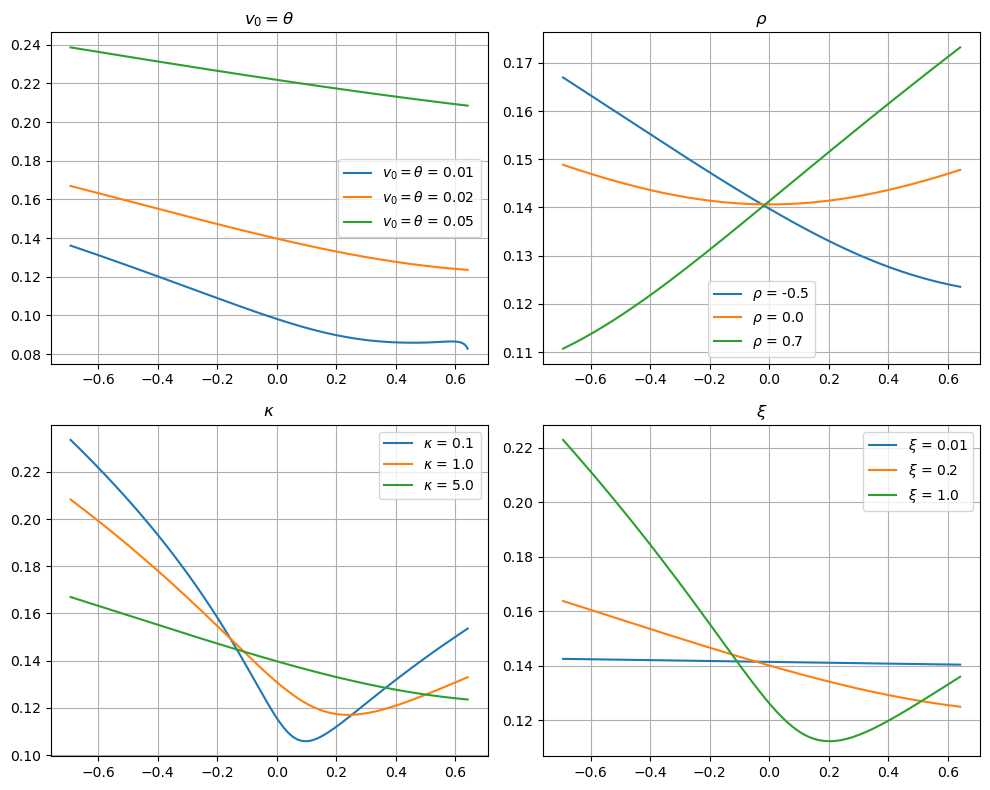

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.reshape(-1)
for i in range(params_grid.shape[0]):
    ax[i].plot(np.log(KK / F), ivs[i].T)
    lgnd = [f'{params_names[i]} = {params_grid[i][j]}' for j in range(3)]
    ax[i].legend(lgnd)
    ax[i].set_title(params_names[i])
    ax[i].grid()
fig.tight_layout()
fig.savefig('../7_figs/implied_vol.jpg')
plt.show()